# Recognition Memory
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4215/7215 --- Fall 2021
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. Some basic probability
2. Strength theories of memory
3. its relation to Signal Detection Theory
4. How to calculate sensitivity (d', or d-prime) and bias (c)
5. Plotting and statistics with d-prime and bias


# New library to install

You're going to need a new plotting library, so run this line at your Anaconda Prompt/Terminal:

`conda install -c conda-forge plotnine` 

In [1]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import plotnine as pn
import scipy.stats.distributions as dists     # probability distributions
from scipy import stats
from glob import glob
import os

from smile.log import log2dl

from ci_within import ci_within

## Custom SLOG loading function

In [89]:
# custom function to load slogs
def load_all_subj_logs(data_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.splitext(os.path.split(filepath)[1])[0].split('_')[0]
             for filepath in glob(os.path.join(data_dir, '*' + log_file + '.slog'))]
    subjs.sort()
    #print(subjs)
    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(data_dir, subj+'_'+log_file+'.slog')
        print(log_path)

        # load the data
        try:
            all_dat.extend(log2dl(log_path, subj=subj))
        except:
            pass

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [121]:
# load the data from each task
data_dir = 'recog_dat'
df_i = load_all_subj_logs(data_dir, 'log_image_test')
df_w = load_all_subj_logs(data_dir, 'log_word_test')
df_i.head()

recog_dat/s000_log_image_test.slog
recog_dat/s001_log_image_test.slog
recog_dat/s002_log_image_test.slog
recog_dat/s003_log_image_test.slog
recog_dat/s004_log_image_test.slog
recog_dat/s005_log_image_test.slog
recog_dat/s006_log_image_test.slog
recog_dat/s007_log_image_test.slog
recog_dat/s008_log_image_test.slog
recog_dat/s009_log_image_test.slog
recog_dat/s010_log_image_test.slog
recog_dat/s011_log_image_test.slog
recog_dat/s012_log_image_test.slog
recog_dat/s000_log_word_test.slog
recog_dat/s001_log_word_test.slog
recog_dat/s002_log_word_test.slog
recog_dat/s003_log_word_test.slog
recog_dat/s004_log_word_test.slog
recog_dat/s005_log_word_test.slog
recog_dat/s006_log_word_test.slog
recog_dat/s007_log_word_test.slog
recog_dat/s008_log_word_test.slog
recog_dat/s009_log_word_test.slog
recog_dat/s010_log_word_test.slog
recog_dat/s011_log_word_test.slog
recog_dat/s012_log_word_test.slog


,resp_map_target,resp_map_lure,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,correct,log_time,filename,in_out,novelty,cond,subj,log_num
0,F,J,0,0,146.028031,0.0,J,146.813776,0.000156,0.785744,False,147.783590,out0571.jpg,outdoor,target,pure,s000,0
1,F,J,0,1,147.787415,0.0,F,148.372070,0.000200,0.584655,True,149.076474,out0110_new.jpg,outdoor,target,pure,s000,0
2,F,J,0,2,149.096004,0.0,F,149.702993,0.000170,0.606989,True,150.628259,out1636.jpg,outdoor,target,pure,s000,0
3,F,J,0,3,150.640249,0.0,F,151.191692,0.000211,0.551444,True,152.167912,out0139_new.jpg,outdoor,target,pure,s000,0
4,F,J,0,4,152.180433,0.0,J,152.837003,0.000165,0.656570,False,153.551730,out0098_new.jpg,outdoor,target,pure,s000,0


## Some data clean-up

In [122]:
# add in log_rt columns
df_i['log_rt'] = np.log(df_i['rt'])
df_w['log_rt'] = np.log(df_w['rt'])

# must make correct an int
df_i['correct'] = df_i['correct'].astype(int)
df_w['correct'] = df_w['correct'].astype(int)

# add in a column for whether they made an 'old' response
df_i['old_resp'] = (df_i['resp_map_target'] == df_i['resp']).astype(int)
df_w['old_resp'] = (df_w['resp_map_target'] == df_w['resp']).astype(int)


In [123]:
df_i.head()

,resp_map_target,resp_map_lure,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,correct,log_time,filename,in_out,novelty,cond,subj,log_num,log_rt,old_resp
0,F,J,0,0,146.028031,0.0,J,146.813776,0.000156,0.785744,0,147.783590,out0571.jpg,outdoor,target,pure,s000,0,-0.241124,0
1,F,J,0,1,147.787415,0.0,F,148.372070,0.000200,0.584655,1,149.076474,out0110_new.jpg,outdoor,target,pure,s000,0,-0.536734,1
2,F,J,0,2,149.096004,0.0,F,149.702993,0.000170,0.606989,1,150.628259,out1636.jpg,outdoor,target,pure,s000,0,-0.499244,1
3,F,J,0,3,150.640249,0.0,F,151.191692,0.000211,0.551444,1,152.167912,out0139_new.jpg,outdoor,target,pure,s000,0,-0.595216,1
4,F,J,0,4,152.180433,0.0,J,152.837003,0.000165,0.656570,0,153.551730,out0098_new.jpg,outdoor,target,pure,s000,0,-0.420726,0


In [125]:
df_i.groupby(['subj'])['correct'].mean()

subj
s000    0.756944
s001    0.812500
s002    0.743056
s003    0.701389
s004    0.810185
s005    0.763889
s006    0.930556
s007    0.953704
s008    0.638889
s009    0.942130
s010    0.951389
s011    0.733796
s012    0.715278
Name: correct, dtype: float64

# Image Recognition Figure

- Recognition memory performance is about more than simply whether you got a response correct
- There are two different ways we are probing memory: 
  - With old (target) items and with new (lure) items
- We can explore that by plotting the probability of making an `old` response, split out by novelty of the test item

In [126]:
# get the error corrected by condition and whether they said old
res = ci_within(df_i,  
                indexvar='subj',       # column that identifies a subject
                withinvars=['cond', 'novelty', 'in_out'],     # list of columns for grouping within subject
                measvar='old_resp')        # dependent variable averaging over
res

mean       std       sem        ci  len
cond  novelty in_out                                              
mixed lure    indoor   0.115385  0.347982  0.016085  0.031609  468
              outdoor  0.119658  0.357795  0.016539  0.032500  468
      target  indoor   0.786325  0.421865  0.019501  0.038320  468
              outdoor  0.717949  0.447980  0.020708  0.040692  468
pure  lure    indoor   0.118590  0.342716  0.011202  0.021984  936
              outdoor  0.149573  0.386301  0.012627  0.024780  936
      target  indoor   0.774573  0.436442  0.014266  0.027996  936
              outdoor  0.683761  0.473378  0.015473  0.030366  936

In [127]:
# must unstack and reset index to plot properly
res.unstack().reset_index()

cond novelty      mean                 std                 sem  \
in_out                   indoor   outdoor    indoor   outdoor    indoor   
0       mixed    lure  0.115385  0.119658  0.347982  0.357795  0.016085   
1       mixed  target  0.786325  0.717949  0.421865  0.447980  0.019501   
2        pure    lure  0.118590  0.149573  0.342716  0.386301  0.011202   
3        pure  target  0.774573  0.683761  0.436442  0.473378  0.014266   

                        ci              len          
in_out   outdoor    indoor   outdoor indoor outdoor  
0       0.016539  0.031609  0.032500    468     468  
1       0.020708  0.038320  0.040692    468     468  
2       0.012627  0.021984  0.024780    936     936  
3       0.015473  0.027996  0.030366    936     936

Text(0, 0.5, 'Performance')

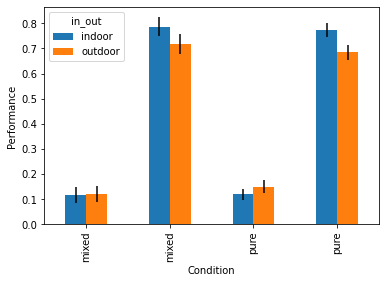

In [128]:
# plot the results
ax = res.unstack().reset_index().plot(x='cond', y='mean', yerr='ci', kind="bar")
#ax.get_legend().remove()
ax.set_xlabel('Condition')
ax.set_ylabel('Performance')

## Can we improve that plot?

- It looks like we've run up against the max level of complexity Pandas can easily handle.
- Let's explore the `plotnine` package, which provides a "Grammar of Graphics" (port of `ggplot` from R to Python)

In [129]:
# we won't need to unstack, but we will still need to reset the index
res = res.reset_index()
res

,cond,novelty,in_out,mean,std,sem,ci,len
0,mixed,lure,indoor,0.115385,0.347982,0.016085,0.031609,468
1,mixed,lure,outdoor,0.119658,0.357795,0.016539,0.032500,468
2,mixed,target,indoor,0.786325,0.421865,0.019501,0.038320,468
3,mixed,target,outdoor,0.717949,0.447980,0.020708,0.040692,468
4,pure,lure,indoor,0.118590,0.342716,0.011202,0.021984,936
5,pure,lure,outdoor,0.149573,0.386301,0.012627,0.024780,936
6,pure,target,indoor,0.774573,0.436442,0.014266,0.027996,936
7,pure,target,outdoor,0.683761,0.473378,0.015473,0.030366,936


## Plotnine / ggplot

- In plotnine, you start with initializing a figure with the data you're going to plot, specifying the general `aesthetics` of what the plot will look like (i.e., what will go on each axis, what colors should they have, how to split out groups, etc...
- Then you add in `geoms` that specify how to map your data to specific visual properties of your figure
- You can also specify rules for how to split out a figure into sub plots
- Finally, you can customize the labels as needed

Let's build this plot, step by step!

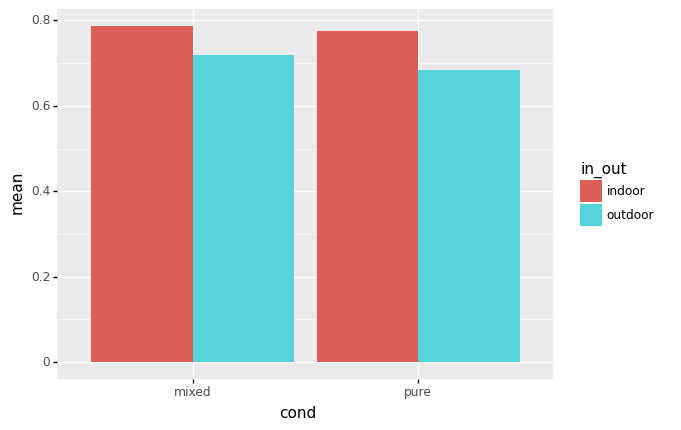

<ggplot: (8752017047053)>

In [130]:
# start with a basic bar plot (specifying to dodge the position, so they are not stacked)
p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='in_out'))
 + pn.geom_bar(stat='identity', position=pn.position_dodge(.9))
)
p

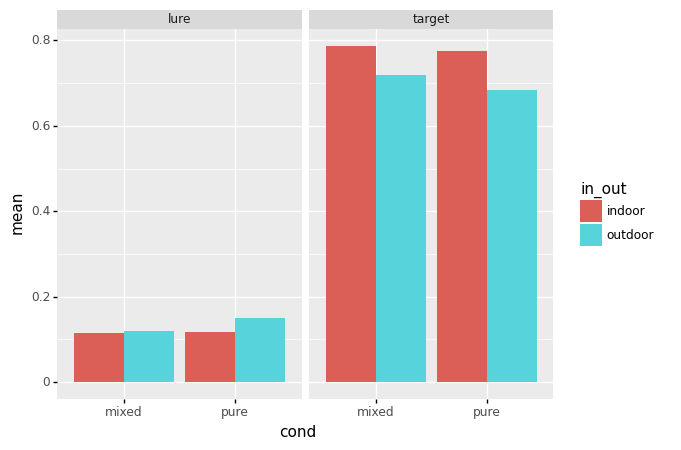

<ggplot: (8752017047053)>

In [131]:
# add in separate plots for novelty because they were on top of each other
p += pn.facet_wrap('~novelty')
p

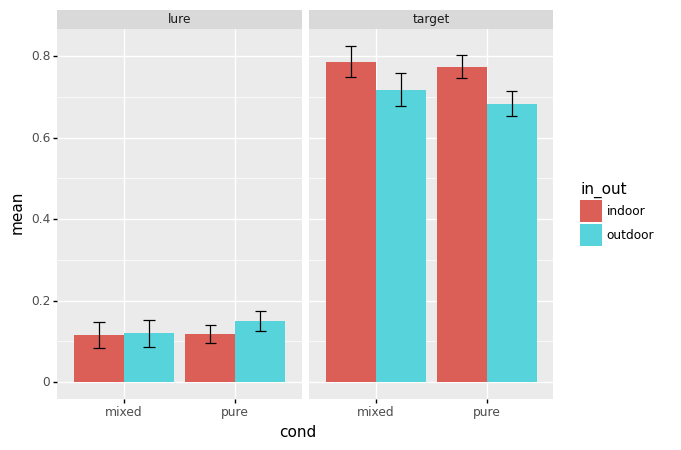

<ggplot: (8752017047053)>

In [132]:
# and now the error bars
p += pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                      position=pn.position_dodge(.9))   # needs to use the same dodge as the bars
p

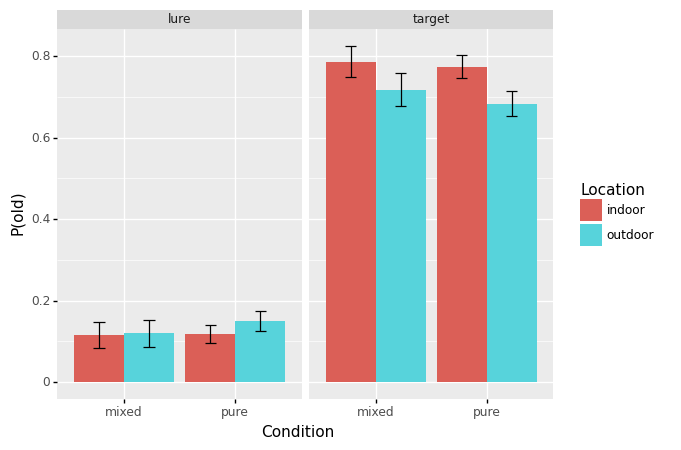

<ggplot: (8752017047053)>

In [133]:
# finally fix up the labels
p += pn.labs(x="Condition", y = "P(old)", fill='Location')
p

## What if we wanted points instead of bars?

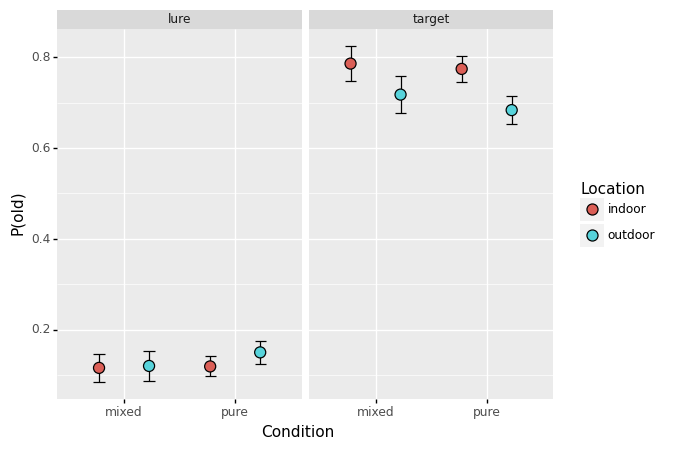

<ggplot: (8752015484070)>

In [134]:
p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='in_out'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.9))
     + pn.geom_point(position=pn.position_dodge(.9), size=4)
     + pn.facet_wrap('~novelty')
     + pn.labs(x="Condition", y = "P(old)", fill='Location')
    )
p

# Probability Theory

At the core of probability theory are the mathematical functions determining the probability of the potential outcomes of an experiment. 

In statistics, these distributions represent the models that attempt to describe the observed data. The equations take in parameters that determine the shape of the probability distributions.

***Note: The area under a probability distribution must equal 1.0!***

## Uniform distribution

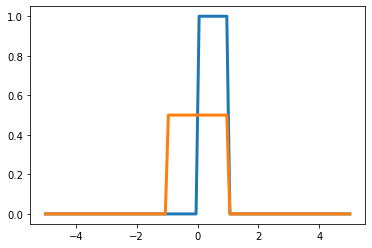

In [135]:
# x values to evaluate
x = np.linspace(-5, 5, 100)

# uniform distribution between 0 and 1
d = dists.uniform(loc=0.0, scale=1.0)
plt.plot(x, d.pdf(x), lw=3)

# uniform distribution between -1 and 1
d = dists.uniform(loc=-1, scale=2.0)
plt.plot(x, d.pdf(x), lw=3)

## The Normal / Gaussian distribution



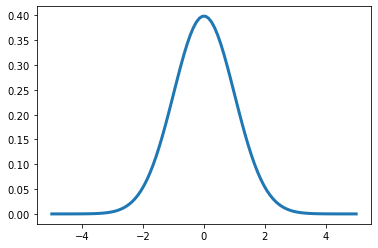

In [136]:
d = dists.norm(loc=0.0, scale=1.0)
x = np.linspace(-5, 5, 100)
plt.plot(x, d.pdf(x), lw=3)


### What's the probability of observing a value greater than 0?

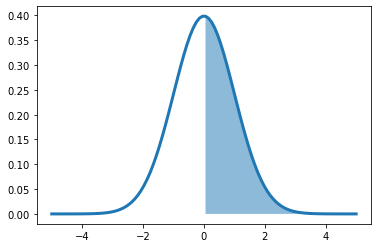

In [137]:
d = dists.norm(loc=0.0, scale=1.0)
x = np.linspace(-5, 5, 100)
plt.plot(x, d.pdf(x), lw=3)
plt.fill_between(x, d.pdf(x), where=x>0.0, alpha=.5)

# Strength theory of memory

- Assumes that we have a baseline familiarity with each item
  - CAT would be strong and have a higher value
  - ALABASTER would be weak and have a lower value
  - VACUUM would have a value somewhere in the middle
- Combining all stimuli gives you a normal distribution of baseline familiarity (i.e., memory strength)
  - This has two parameters, the mean and standard deviation of the normal distribution

## The effect of studying and item

- In strength theory, the process of studying an item adds some amount to that baseline familiarity for some item
- Thus, studying a set of items shifts their strength distribution to the right!

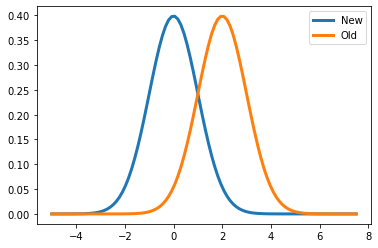

In [138]:
mu = 0.0
sigma = 1.0
alpha = 2.0

# xrange to plot
x = np.linspace(-5, 7.5, 100)

# distribution of new items
y1 = dists.norm(loc=mu, scale=sigma).pdf(x)
plt.plot(x, y1, lw=3)

# distribution of old (studied) items
y2 = dists.norm(loc=mu+alpha, scale=sigma).pdf(x)
plt.plot(x, y2, lw=3)

plt.legend(['New', 'Old'])


# Signal Detection Theory

- Developed by radar operators in the 1940s to help make decisions under uncertainty
- Casts the decision as detecting signal versus noise
- Adds one more parameter, the decision criterion (C)

![SDT](figs/signal_detection.png)



## Bias: How do we pick our decision criterion?

- You don't have control over the signal and noise distributions, but you do have control over the criterion
- Questions:
  - Where should you put your criterion to make the fewest errors?
  - Where should you put your criterion if I said you would get $10 for every hit, and take away nothing for false alarms?
  - How about if you had to pay me every time you made a false alarm?

## Calculating sensitivity

- Under assumptions of equal variance for both the signal and noise distributions, the d' (d-prime) is the measure of sensitivity

$$d' = \frac{((\mu + \alpha) - \mu)}{\sigma}$$


$$d' = \frac{\alpha}{\sigma}$$

- Thus, $d'$ is the difference between the two distributions in units of the standard deviation
- Note, this is independent of the criterion


In [139]:
def calc_dprime(n_hits, n_targets, n_false_alarms, n_lures):
    # calculate corrected hit rate and false alarm rate (to avoid zeros)
    hr_trans = (n_hits+.5)/(n_targets+1)
    far_trans = (n_false_alarms+.5)/(n_lures+1)
    
    # calculate dprime
    Z = dists.norm.ppf
    dprime = Z(hr_trans) - Z(far_trans)
    return dprime

def calc_c(n_hits, n_targets, n_false_alarms, n_lures):
    # calculate corrected hit rate and false alarm rate (to avoid zeros)
    hr_trans = (n_hits+.5)/(n_targets+1)
    far_trans = (n_false_alarms+.5)/(n_lures+1)
    
    # calculate bias
    Z = dists.norm.ppf
    c = -(Z(hr_trans) + Z(far_trans)) / 2
    return c


In [140]:
# use the agg method to get the counts
iperf = df_i.groupby(['subj', 'cond', 'in_out', 'novelty'])['old_resp'].agg(['sum', 'count', 'mean'])
iperf = iperf.unstack().reset_index()

# collapse the multi-index
iperf.columns = ['_'.join(col).strip() if len(col[1]) > 0 else col[0] 
                 for col in iperf.columns.values]
iperf.head()

,subj,cond,in_out,sum_lure,sum_target,count_lure,count_target,mean_lure,mean_target
0,s000,mixed,indoor,2,23,36,36,0.055556,0.638889
1,s000,mixed,outdoor,5,29,36,36,0.138889,0.805556
2,s000,pure,indoor,11,46,72,72,0.152778,0.638889
3,s000,pure,outdoor,19,50,72,72,0.263889,0.694444
4,s001,mixed,indoor,4,32,36,36,0.111111,0.888889


## Use `apply` to run the functions on each row

In [141]:
# add the dprime as a new column (axis=1 tells it to go by row)
iperf['dprime'] = iperf.apply(lambda x: calc_dprime(x['sum_target'], x['count_target'],
                                                    x['sum_lure'], x['count_lure']),
                                  axis=1)
# add bias (c) as a new column
iperf['c'] = iperf.apply(lambda x: calc_c(x['sum_target'], x['count_target'],
                                                    x['sum_lure'], x['count_lure']),
                                  axis=1)

iperf

,subj,cond,in_out,sum_lure,sum_target,count_lure,count_target,mean_lure,mean_target,dprime,c
0,s000,mixed,indoor,2,23,36,36,0.055556,0.638889,1.839640,5.743349e-01
1,s000,mixed,outdoor,5,29,36,36,0.138889,0.805556,1.874253,1.051202e-01
2,s000,pure,indoor,11,46,72,72,0.152778,0.638889,1.355058,3.271144e-01
3,s000,pure,outdoor,19,50,72,72,0.263889,0.694444,1.122441,6.031610e-02
4,s001,mixed,indoor,4,32,36,36,0.111111,0.888889,2.333837,-3.330669e-16
5,s001,mixed,outdoor,5,25,36,36,0.138889,0.694444,1.535800,2.743467e-01
6,s001,pure,indoor,2,55,72,72,0.027778,0.763889,2.528933,5.572822e-01
7,s001,pure,outdoor,5,39,72,72,0.069444,0.541667,1.540311,6.669607e-01
8,s002,mixed,indoor,4,20,36,36,0.111111,0.555556,1.302829,5.155040e-01
9,s002,mixed,outdoor,4,19,36,36,0.111111,0.527778,1.234717,5.495600e-01


## Plotting d prime

Now that we have our sensitivity, let's see if there is any consistent result between conditions

In [142]:
res = ci_within(iperf, indexvar='subj', 
                withinvars=['cond', 'in_out'], 
                measvar='dprime').reset_index()
res

,cond,in_out,mean,std,sem,ci,len
0,mixed,indoor,2.201667,0.526798,0.146108,0.318341,13
1,mixed,outdoor,1.933758,0.511105,0.141755,0.308858,13
2,pure,indoor,2.164407,0.558385,0.154868,0.337429,13
3,pure,outdoor,1.713244,0.380180,0.105443,0.229741,13


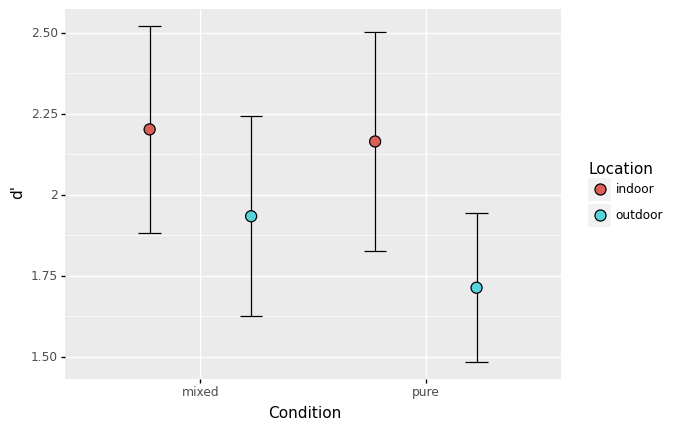

<ggplot: (8752015942199)>

In [143]:
p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='in_out'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.9))
     + pn.geom_point(position=pn.position_dodge(.9), size=4)
     + pn.labs(x="Condition", y = "d'", fill='Location')
    )
p

## Let's run a linear model!

In [144]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [145]:
# build a least squares regression
model = smf.ols("dprime ~ cond * in_out", iperf).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 dprime   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.6388
Date:                Thu, 04 Nov 2021   Prob (F-statistic):              0.594
Time:                        12:23:53   Log-Likelihood:                -72.884
No. Observations:                  52   AIC:                             153.8
Df Residuals:                      48   BIC:                             161.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          2.2017      0.284      7.760      0.000       1.631       2.772
cond[T.pure]                      -0.0373      0.401     -0.093      0.926      -0.844       0.769
in_out[T.outdoor]                 -0.2679      0.401     -0.668      0.508      -1.075       0.539
cond[T.pure]:in_out[T.outdoor]    -0.1833      0.567     -0.323      0.748      -1.324       0.958
==============================================================================
Omnibus:                        4.068   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.131   Jarque-Bera (JB):                3.736
Skew:                           0.586   Prob(JB):                        0.154
Kurtosis:                       2.407   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
cond,0.215955,1.0,0.206371,0.651675
in_out,1.680458,1.0,1.605877,0.211186
cond:in_out,0.109141,1.0,0.104297,0.748135
Residual,50.229246,48.0,NaN,NaN


## What about bias?

It could be that there is a systematic bias in the responses due to the image types.

In [147]:
res = ci_within(iperf, indexvar='subj', 
                withinvars=['cond', 'in_out'], 
                measvar='c').reset_index()
res

,cond,in_out,mean,std,sem,ci,len
0,mixed,indoor,0.194484,0.263055,0.072958,0.158963,13
1,mixed,outdoor,0.200518,0.255986,0.070998,0.154691,13
2,pure,indoor,0.212213,0.198186,0.054967,0.119763,13
3,pure,outdoor,0.314609,0.275230,0.076335,0.166320,13


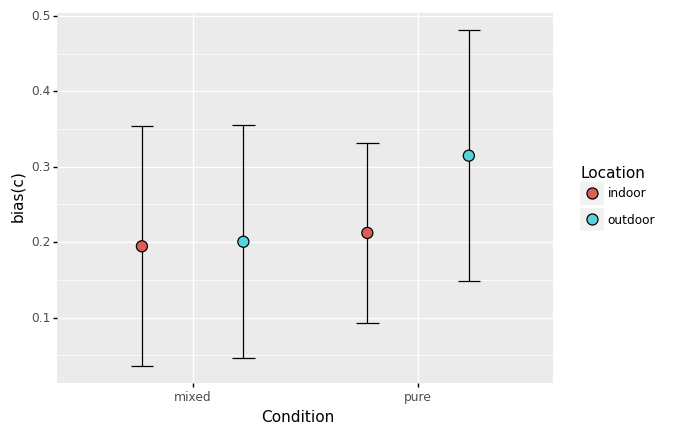

<ggplot: (8752015590238)>

In [148]:
p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='in_out'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.9))
     + pn.geom_point(position=pn.position_dodge(.9), size=4)
     + pn.labs(x="Condition", y = "bias(c)", fill='Location')
    )
p

In [149]:
# build a linear regression of the full model
m0 = smf.ols("c ~ cond * in_out", iperf).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      c   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                    0.3437
Date:                Thu, 04 Nov 2021   Prob (F-statistic):              0.794
Time:                        12:23:58   Log-Likelihood:                -16.813
No. Observations:                  52   AIC:                             41.63
Df Residuals:                      48   BIC:                             49.43
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.1945      0.097      2.015      0.050       0.000       0.389
cond[T.pure]                       0.0177      0.136      0.130      0.897      -0.257       0.292
in_out[T.outdoor]                  0.0060      0.136      0.044      0.965      -0.268       0.280
cond[T.pure]:in_out[T.outdoor]     0.0964      0.193      0.499      0.620      -0.292       0.484
==============================================================================
Omnibus:                        0.833   Durbin-Watson:                   1.028
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.905
Skew:                           0.198   Prob(JB):                        0.636
Kurtosis:                       2.489   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [150]:
sm.stats.anova_lm(m0, typ=2)

,sum_sq,df,F,PR(>F)
cond,0.056475,1.0,0.466362,0.497949
in_out,0.038211,1.0,0.315536,0.576916
cond:in_out,0.030178,1.0,0.249207,0.619914
Residual,5.812656,48.0,NaN,NaN


## Conclusion

- We see an effect in old items, whereby participants are less likely to respond 'old' for outdoor items, but nothing in dprime or bias.
- This is regardless of whether the list is mixed or pure.

## Assignment before next class

- We will post a small set of analyses to run on the word memory data based on the examples in this class
- This will be due on ***Thursday*** next week

### See you next week!!!